In [263]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, ConfusionMatrixDisplay, roc_curve, roc_auc_score, accuracy_score, auc
from imblearn.over_sampling import RandomOverSampler
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler 

In [264]:
df = pd.read_csv('week_07/Credit_Card.csv')
label_df = pd.read_csv('week_07/Credit_card_label.csv')
cc_df = pd.merge(df, label_df, on='Ind_ID')
ros = RandomOverSampler(random_state=42)
cc_df.head()


,Ind_ID,GENDER,Car_Owner,Propert_Owner,CHILDREN,Annual_income,Type_Income,EDUCATION,Marital_status,Housing_type,Birthday_count,Employed_days,Mobile_phone,Work_Phone,Phone,EMAIL_ID,Type_Occupation,Family_Members,label
0,5008827,M,Y,Y,0,180000.0,Pensioner,Higher education,Married,House / apartment,-18772.0,365243,1,0,0,0,NaN,2,1
1,5009744,F,Y,N,0,315000.0,Commercial associate,Higher education,Married,House / apartment,-13557.0,-586,1,1,1,0,NaN,2,1
2,5009746,F,Y,N,0,315000.0,Commercial associate,Higher education,Married,House / apartment,NaN,-586,1,1,1,0,NaN,2,1
3,5009749,F,Y,N,0,NaN,Commercial associate,Higher education,Married,House / apartment,-13557.0,-586,1,1,1,0,NaN,2,1
4,5009752,F,Y,N,0,315000.0,Commercial associate,Higher education,Married,House / apartment,-13557.0,-586,1,1,1,0,NaN,2,1


### Cleaning improvments:

 - standardize column names

In [265]:
def standardize_column_names(df: pd.DataFrame) -> pd.DataFrame:
    """
    Standardizes column names
    """
    cc_df.columns = df.columns.str.strip()  
    cc_df.columns = df.columns.str.lower() 

def fill_nan(df: pd.DataFrame, col: str, tendency: str) -> pd.Series:
    '''
    takes in a dataframe, column, and what value to use in place of NaN values
    '''
    if tendency == 'mean':
        df[col] = df[col].fillna(df[col].mean())
    elif tendency == 'median':
        df[col] = df[col].fillna(df[col].median())
    elif tendency == 'mode':
        df[col] = df[col].fillna(df[col].mode().iloc[0])

def encode_cat(df: pd.DataFrame, col: str) -> pd.Series:
    '''
    encodes categorical values
    '''
    val_map = {}
    code = 0
    for value in df[col].unique():
        if value not in val_map:
            val_map[value] = code
            code+=1
    df[col] = df[col].map(val_map)
    
def clean(cc_df: pd.DataFrame) -> pd.DataFrame:
    """
    Performs all cleaning operations on cc_df 
    """
    
    standardize_column_names(cc_df)

    cc_df = cc_df.drop(['type_occupation', 'phone'], axis=1)

    fill_nan(cc_df, 'gender', 'mode')
    fill_nan(cc_df, 'annual_income', 'median')
    fill_nan(cc_df, 'birthday_count', 'median')

    cc_df['birthday_count'] = cc_df['birthday_count'].astype(int)
    cc_df['annual_income'] = cc_df['annual_income'].astype(int)
    
    categorical_cols = ['gender', 'car_owner', 'propert_owner', 
                        'type_income', 'education', 'marital_status', 
                        'housing_type']
    for col in categorical_cols:
        encode_cat(cc_df, col)
    
    return cc_df

df = clean(cc_df)
df.head(10)
 

,ind_id,gender,car_owner,propert_owner,children,annual_income,type_income,education,marital_status,housing_type,birthday_count,employed_days,mobile_phone,work_phone,email_id,family_members,label
0,5008827,0,0,0,0,180000,0,0,0,0,-18772,365243,1,0,0,2,1
1,5009744,1,0,1,0,315000,1,0,0,0,-13557,-586,1,1,0,2,1
2,5009746,1,0,1,0,315000,1,0,0,0,-15661,-586,1,1,0,2,1
3,5009749,1,0,1,0,166500,1,0,0,0,-13557,-586,1,1,0,2,1
4,5009752,1,0,1,0,315000,1,0,0,0,-13557,-586,1,1,0,2,1
5,5009753,1,0,1,0,315000,0,0,0,0,-13557,-586,1,1,0,2,1
6,5009754,1,0,1,0,315000,1,0,0,0,-13557,-586,1,1,0,2,1
7,5009894,1,1,1,0,180000,0,1,0,0,-22134,365243,1,0,0,2,1
8,5010864,0,0,0,1,450000,1,1,0,0,-18173,-678,1,0,1,3,1
9,5010868,0,0,0,1,450000,0,1,0,0,-18173,-678,1,0,1,3,1


Cleaning process:
 - standardize column names (improvement)
 - replace empty values
 - encode categorical data 
 - convert float values to integers, since they represent whole numbers anyway (improvement)

 


### 2. Sampling

since theres a significant imbalance in the class distribution (almost 9:1), it makes sense to oversample the minority class

In [266]:
def optimal_knn() -> float:
    '''
    we can find the optimal k value by calculating the accuracy score for each value of k 
    in a predetermined range and returning the value that gives us the best score
    we can then use that value to perform KNN 
    '''
    X = df.drop('label', axis=1)
    y = df['label']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42,)


    X_train_resampled, y_train_resampled = ros.fit_resample(X_train, y_train)

    high_score = 0
    opt_k = 0
    for k in range(1, 20):
        knn = KNeighborsClassifier(n_neighbors = k)
        knn.fit(X_train_resampled, y_train_resampled)
        y_probs = knn.predict_proba(X_test)[:, 1] 
        y_pred = knn.predict(X_test)
        score = knn.score(X_test, y_test)
        if score > high_score:
            high_score = score
            opt_k = k 
    print(classification_report(y_test, y_pred))
    return opt_k


optimal_knn()

              precision    recall  f1-score   support

           0       0.92      0.55      0.68       422
           1       0.11      0.53      0.18        43

    accuracy                           0.54       465
   macro avg       0.51      0.54      0.43       465
weighted avg       0.84      0.54      0.64       465



1

In [267]:
def logistic_regression() -> float:
    X = df.drop('label', axis=1)
    y = df['label']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
    X_train_resampled, y_train_resampled = ros.fit_resample(X_train, y_train)
    regression = LogisticRegression(random_state=42).fit(X_train_resampled, y_train_resampled)
    r2=regression.score(X_test, y_test)
    return r2
    
logistic_regression()

0.5741935483870968

### 3. ROC and AUC


              precision    recall  f1-score   support

           0       0.92      0.55      0.68       422
           1       0.11      0.53      0.18        43

    accuracy                           0.54       465
   macro avg       0.51      0.54      0.43       465
weighted avg       0.84      0.54      0.64       465



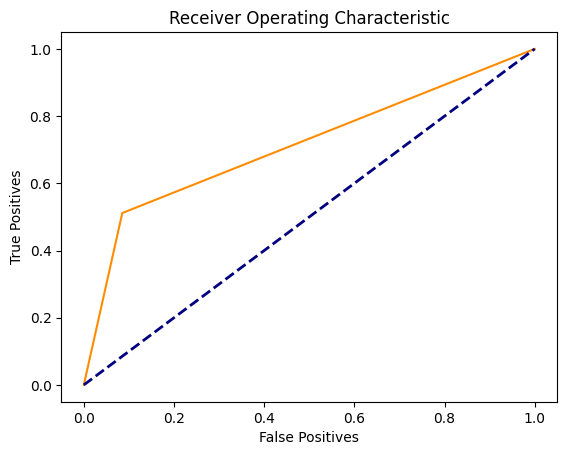

AUC: 0.7131599250523531


In [277]:
def roc_plot(opt_k=2)-> plt.plot:
    '''
    Plots the ROC curve and calculates the AUC score for the optimal KNN model.
    '''
    X = df.drop('label', axis=1)
    y = df['label']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

    X_train_resampled, y_train_resampled = ros.fit_resample(X_train, y_train)

    opt_k = optimal_knn()
    knn = KNeighborsClassifier(n_neighbors=opt_k)
    knn.fit(X_train_resampled, y_train_resampled)
    y_probs = knn.predict_proba(X_test)[:, 1]  

    fpr, tpr, thresholds = roc_curve(y_test, y_probs)
    roc_auc = auc(fpr, tpr)

    plt.plot(fpr, tpr, color='darkorange')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlabel('False Positives')
    plt.ylabel('True Positives')
    plt.title('Receiver Operating Characteristic')
    plt.show()

    print(f"AUC: {roc_auc}")
roc_plot()    

### 4. SVM

In [ ]:
def svm_model(data: pd.DataFrame=df, col: str='label'):
    X = df.drop('label', axis=1)
    y = df['label']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

    classifier = SVC(kernel='linear', random_state=42)
    classifier.fit(X_train, y_train)

    y_pred = classifier.predict(X_test)

    accuracy = accuracy_score(y_test,y_pred)
    return accuracy
    
svm_model()

0.9075268817204301

SVM performed well with an accuracy of 0.907

### 5. Outlier detection
Outlier detection finds data points that are significantly different from the majority. This is important because having outliers in our data can effect the performance of a model. Common statistical methods for outlier detection are Z-Scores and Interquartile Range